# Практическая работа 1

## Тема: "Программная реализация многослойного персептрона"

### Цель: изучение архитектуры нейронной сети; создание и исследование нейронной сети для задачи классификации на языке Python.

In [1]:
import torch
import torchvision
import collections
import numpy as np 
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from sklearn.datasets import load_boston
from tqdm import tqdm

%matplotlib inline

Выбор нужных классов

In [2]:
label_need = [0,6,9]

In [3]:
def label_transform(x):
    """Преобразовываем лайблы для дальнейшей работы
        Далее не получится взять необходимые классы, 
        без предобработки."""
    
    if x in label_need:
        return label_need.index(x)
    return -1

In [4]:
# Загружаем train set
train_data = torchvision.datasets.FashionMNIST(
    './mnist/', train=True, download=True, 
    transform=torchvision.transforms.ToTensor(),
    target_transform = label_transform
)

# Загружаем test set
test_data = torchvision.datasets.FashionMNIST(
    './mnist/', train=False, download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform = label_transform
) 

Посмотрим как выглядят данные

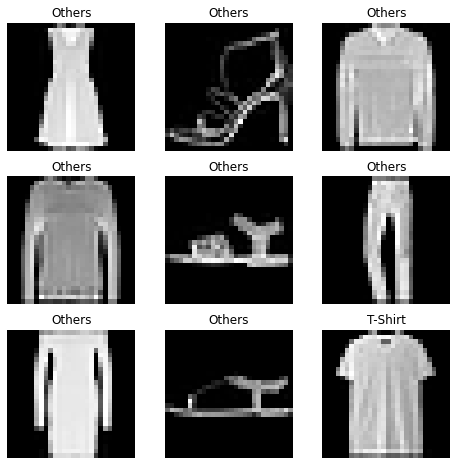

In [5]:
output_mapping = {
    0: "T-Shirt",
    1: "Shirt",
    2: "Boats",
    -1: "Others",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(output_mapping[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Выбор нужных классов

In [6]:
need_train_index = [i for i, data in enumerate(train_data) if data[1] >= 0]
need_test_index = [i for i, data in enumerate(test_data) if data[1] >= 0]

In [7]:
print("Размер train по заданию", len(need_train_index))
print("Размер test", len(need_test_index))

Размер train по заданию 18000
Размер test 3000


Разделение выборки на valid и test

In [8]:
from sklearn.model_selection import train_test_split
X = need_train_index
y = [train_data[i][1] for i in need_train_index]

In [9]:
train_index, valid_index, _, _ = train_test_split(X, y, train_size=5/6, 
                                            random_state=42,
                                               stratify=y)

In [10]:
len(train_index)

15000

In [11]:
len(valid_index)

3000

In [12]:
# Преобразование данных
train_set = torch.utils.data.Subset(train_data, train_index)
valid_set = torch.utils.data.Subset(train_data, valid_index)
test_set = torch.utils.data.Subset(test_data, need_test_index)

In [13]:
# DataLoader
train_dl = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
valid_dl = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=0)

Распределение классов

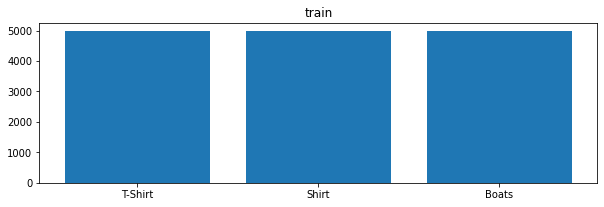

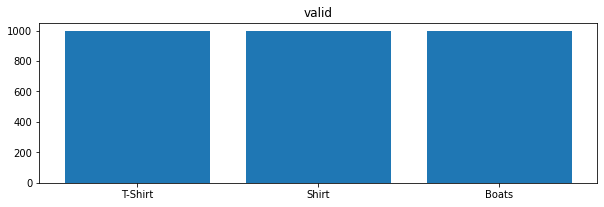

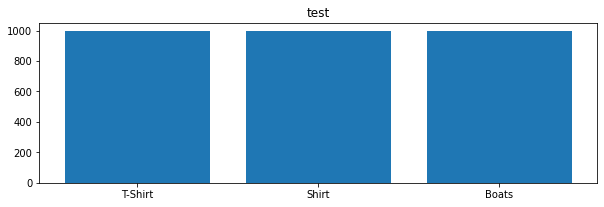

In [14]:
for i, data_set in enumerate([train_set, valid_set, test_set]):
    plt.figure(figsize =(10, 10))
    plt.subplot(3, 1, i + 1)
    label = [output_mapping[j] for j in [0, 1, 2]]
    value = [collections.Counter([data[1] for data in data_set])[j] for j in [0, 1, 2]]
    plt.bar(label, value)
    plt.title(["train", "valid", "test"][i])
plt.show()

In [15]:
# Подключение видеокарты
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
device

device(type='cuda')

In [16]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    """
    Функция обучения сети и проверки на валидации.
    """
    train_losses = []
    val_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for xb, yb in tqdm(train_dl):
            xb = torch.reshape(xb,(-1, 28*28))
            xb, yb = xb.to(device), yb.to(device)
            
            loss = loss_func(model(xb), yb)
            loss_sum += loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval()
        loss_sum = 0
        correct = 0
        num = 0
        with torch.no_grad():
            for xb, yb in tqdm(valid_dl):
                xb = torch.reshape(xb,(-1, 28*28))
                xb, yb = xb.to(device), yb.to(device)
                
                probs = model(xb)
                loss_sum += loss_func(probs, yb).item()
                
                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)
                
        val_losses.append(loss_sum / len(valid_dl))
        valid_accuracies.append(correct / num)
        
    return train_losses, val_losses, valid_accuracies

In [17]:
def plot_train(train_losses, valid_losses, valid_accuracies):
    """
    Отрисовка графиков loss функции и accuracy.
    Так же выводится число точности на последней эпохи
    в valid.
    """
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_losses, label="train_loss")
    plt.plot(valid_losses, label="valid_loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()
    print("valid accuracy", valid_accuracies[-1])

In [18]:
class ModelThreeLayers(nn.Module):
    def __init__(self):
        super(ModelThreeLayers, self).__init__()
        self.fc1 = nn.Linear(28*28, 700)
        self.fc2 = nn.Linear(700, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, 1)
        return x

In [19]:
model_three_layers = ModelThreeLayers().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_three_layers.parameters(), lr=0.001, momentum=0.9)

info_model_three_layers = fit(10, model_three_layers, criterion, optimizer, train_dl, valid_dl)

100%|█████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 129.44it/s]


valid accuracy 0.8853333333333333


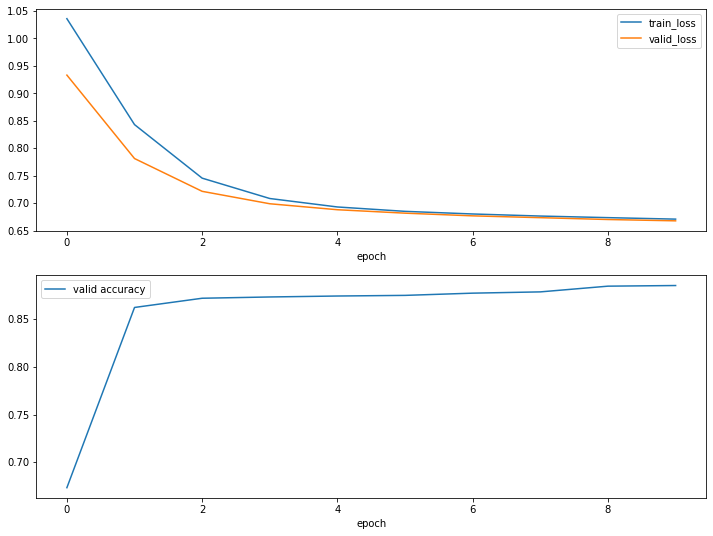

In [20]:
plot_train(*info_model_three_layers)

In [21]:
class ModelTwoLayersSigmoid(nn.Module):
    def __init__(self):
        super(ModelTwoLayersSigmoid, self).__init__()
        self.fc1 = nn.Linear(28*28, 128) 
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = nn.Sigmoid()(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, 1)
        return x

In [22]:
model_two_layers_sigm = ModelTwoLayersSigmoid().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_two_layers_sigm.parameters(), lr=0.003, momentum=0.9)

info_model_two_layers_sigm = fit(10, model_two_layers_sigm, criterion, optimizer, train_dl, valid_dl)

100%|█████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 126.68it/s]


valid accuracy 0.8806666666666667


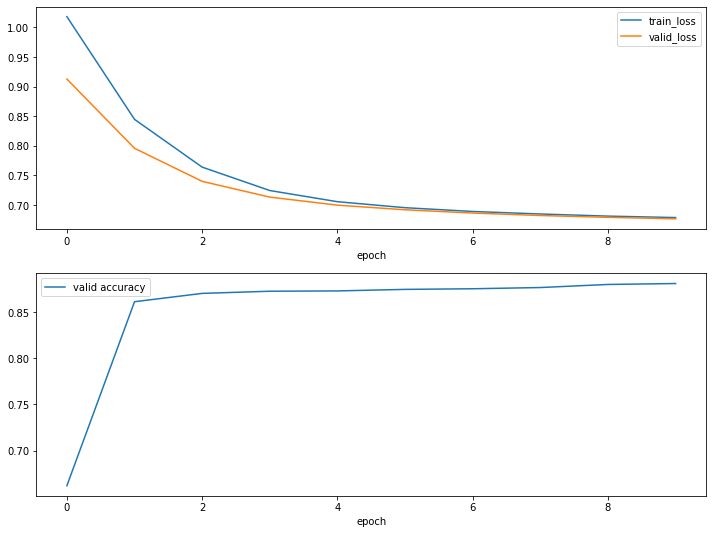

In [23]:
plot_train(*info_model_two_layers_sigm)

In [24]:
class ModelDropBatch(nn.Module):
    def __init__(self):
        super(ModelDropBatch, self).__init__()
        self.fc1 = nn.Linear(28*28, 700)
        self.fc2 = nn.Linear(700, 400)
        self.fc3 = nn.Linear(400, 3)
        self.bn = nn.BatchNorm1d(700)
        self.dp1 = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.bn(F.relu(self.fc1(x)))
        x = self.dp1(F.relu(self.fc2(x)))
        x = self.fc3(x)
        x = F.softmax(x, 1)
        return x

In [ ]:
model_drop_batch = ModelDropBatch().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_drop_batch.parameters(), lr=0.009)

info_model_drop_batch = fit(10, model_drop_batch, criterion, optimizer, train_dl, valid_dl)

 37%|█████████████████████████████▉                                                  | 88/235 [00:00<00:01, 100.27it/s]

In [ ]:
plot_train(*info_model_drop_batch)

Функция активации (выходная) LogSoftmax

In [ ]:
class ModelLogSoftmax(nn.Module):
    def __init__(self):
        super(ModelLogSoftmax, self).__init__()
        self.fc1 = nn.Linear(28*28, 10)
        self.fc3 = nn.Linear(10, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        x = nn.LogSoftmax(dim=1)(x)
        return x

In [ ]:
model_logsoftmax = ModelLogSoftmax().to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model_logsoftmax.parameters(), lr=0.0001)

info_model_logsoftmax = fit(7, model_logsoftmax, criterion, optimizer, train_dl, valid_dl)

In [ ]:
plot_train(*info_model_logsoftmax)

## Проверка на тестовой выборке и выбор лучшей модели

In [ ]:
list_model = [model_three_layers, model_two_layers_sigm, model_drop_batch, model_logsoftmax]
model_name = ["model_three_layers", "model_two_layers_sigm", "model_drop_batch", "model_logsoftmax"]

In [ ]:
test_accuracies = []
for i, model in enumerate(list_model):
    model.eval()
    correct = 0
    num = 0
    with torch.no_grad():
        for xb, yb in tqdm(valid_dl):
                xb = torch.reshape(xb,(-1, 28*28))
                xb, yb = xb.to(device), yb.to(device)
                
                probs = model(xb)
                
                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)
        
    test_accuracies.append(correct / num)

In [ ]:
plt.figure(figsize =(10, 8))
plt.subplot(1, 1, 1)
plt.ylabel("test_accuracies")
plt.bar(model_name, test_accuracies)
      
plt.show()
print("accuracies:",test_accuracies)